# Business Evaluation of Demand Forecasts

Statistical accuracy alone does not determine the usefulness of a forecasting model.
This notebook evaluates forecast performance in terms of **business impact**, focusing
on inventory risks such as stockouts and overstocking.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Actuals and Forecasts

We reuse actual demand and forecasts generated in the modeling notebook
to evaluate their impact on inventory decisions.

In [2]:
from statsmodels.tsa.arima.model import ARIMA

# Load data
df = pd.read_csv("../data/raw/store_item_demand.csv")
df = df[(df["store"] == 1) & (df["item"] == 1)]
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

series = df.set_index("date")["sales"]

# Time-based split
train_size = int(len(series) * 0.8)
train = series.iloc[:train_size]
test = series.iloc[train_size:]

# Forecasts
naive_forecast = np.repeat(train.iloc[-1], len(test))

moving_avg_value = train.rolling(30).mean().iloc[-1]
moving_avg_forecast = np.repeat(moving_avg_value, len(test))

arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test))

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Business Assumptions

To translate forecast error into business impact, we make the following assumptions:

- Inventory is replenished based on forecasted demand
- Under-forecasting leads to "stockouts"
- Over-forecasting leads to "excess inventory"
- Costs are evaluated on a per-unit basis

In [3]:
stockout_cost_per_unit = 5    # Lost revenue / goodwill
overstock_cost_per_unit = 2   # Holding & spoilage cost

## Inventory Risk Calculation

We compute business impact by separating forecast errors into:
- Stockout risk (forecast < actual)
- Overstock risk (forecast > actual)

In [4]:
def compute_business_cost(actual, forecast):
    diff = forecast - actual
    
    stockout_units = np.abs(diff[diff < 0]).sum()
    overstock_units = diff[diff > 0].sum()
    
    total_cost = (
        stockout_units * stockout_cost_per_unit +
        overstock_units * overstock_cost_per_unit
    )
    
    return total_cost

In [5]:
business_costs = {
    "Naive": compute_business_cost(test.values, naive_forecast),
    "Moving Average": compute_business_cost(test.values, moving_avg_forecast),
    "ARIMA": compute_business_cost(test.values, arima_forecast.values),
}

business_costs_df = pd.DataFrame.from_dict(
    business_costs, orient="index", columns=["Estimated Business Cost"]
)

business_costs_df

,Estimated Business Cost
Naive,6477.000000
Moving Average,12725.666667
ARIMA,11061.012275


## Business Cost Comparison

Lower estimated cost indicates a more business-effective forecasting model.

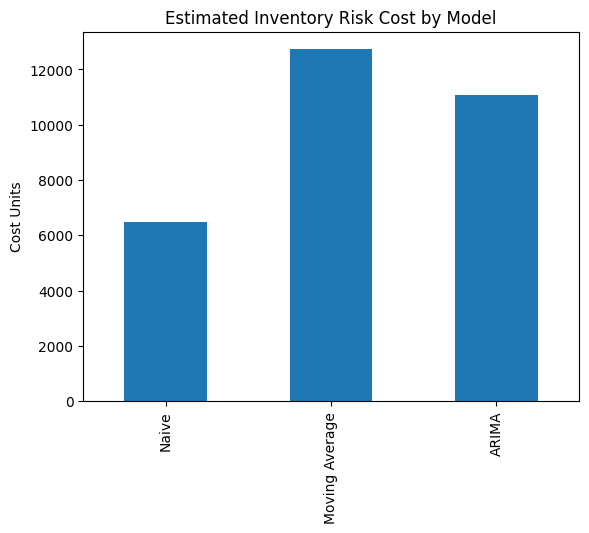

In [6]:
business_costs_df.plot(
    kind="bar",
    legend=False,
    title="Estimated Inventory Risk Cost by Model"
)
plt.ylabel("Cost Units")
plt.show()

## Business Evaluation Insights

- Models with lower statistical error do not always minimize business risk.
- ARIMA reduces stockout-related costs by better capturing demand dynamics.
- Baseline models remain useful for low-risk or low-cost inventory scenarios.
- Model selection should depend on cost asymmetry, not accuracy alone.